# Travis Lloyd


# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import regex as re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need



In [3]:
# Place any addtional functions or constants you need here. 
def top_ten(doc, all_tokens):
    counter = Counter(doc)
    counter2 = dict(counter)
    counter_zip = list(zip(counter2.keys(),counter2.values()))
    new_list = []
    x = 0
    z = 0
    print(f'There are {len(counter_zip)} tokens in this corpus')
    for i in counter_zip:
        if i[1] <5:
#             counter_zip.pop(counter_zip.index(i))
            x += 1
        if i[1] >= 5:
            y = list(i)
            y[1] = round((y[1]/all_tokens[y[0]]),3)
            i = tuple(y)
            new_list.append(i)
            z += 1
    new_list.sort(reverse=True)
    print(f'{x} tokens were under the threshold')
    print(f'{z} tokens analyzed')
    print(new_list[0:9])
    return(dict(new_list))


class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

# for country in emoji.UNICODE_EMOJI : 
#     for em in emoji.UNICODE_EMOJI[country] : 
#         all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = 0
    for i in tokens:
        num_characters += len(i)
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        counter = Counter(tokens) 
        most_common = counter.most_common(5)
        print(f'The 5 most common tokens are: {most_common}')
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

    
    return(0)


    
def is_emoji(s):
    return(emoji.is_emoji(s))

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    return[t for t in tokens if t.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)
def remove_title(text):
    text = str(text)
    text = text.split('"',2)[2]
    return(text)
    


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [5]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/travis/mod2/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

# Read in Twitter Data for each artist
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'], sep="\t", quoting=3)
twitter_data['artist'] = "cher"
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'], sep="\t", quoting=3)
twitter_data_2['artist'] = "robyn"
twitter_data = pd.concat([twitter_data,twitter_data_2])
del(twitter_data_2)

# read in the lyrics here
lyric_df = pd.DataFrame()

with os.scandir(data_location + lyrics_folder) as artist:
    for artist in artist:
        if not artist.name.startswith('.') and artist.is_dir():
            with os.scandir(artist.path) as songs:
                    for song in songs:
                        if not song.name.startswith('.'):
                            with open(song.path) as f:
                                lines = f.read()
                            lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [6]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyric_df['content'] = lyric_df['content'].apply(remove_title)
lyric_df["tokens"] = lyric_df["content"].apply(prepare,pipeline=my_pipeline)
lyric_df["num_tokens"] = lyric_df["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [7]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [8]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
2501389,cher,gay as hell 👌🏼,"[gay, hell]"
1825584,cher,Απο μικρος μου άρεσαν τα ταξίδια Μεγάλωσα και ...,"[απο, μικρος, μου, άρεσαν, τα, ταξίδια, μεγάλω..."
937249,cher,25 | 👓📷🏳️‍🌈 | she/her | “May we all have the c...,"[sheher, may, confidence, mediocre, white, man..."
1581139,cher,"Pres. of Ricardo Sandoval fan club, cat herder...","[pres, ricardo, sandoval, fan, club, cat, herd..."
931407,cher,19🌙⛥|Singer🎤Songwriter✍|Model🤵🏽|Dancer🕺🏽|Activ...,"[singer, songwriter, model, dancer, activist, ..."
1058634,cher,"All things #StarTrek, Personal Trainer (Online...","[things, startrek, personal, trainer, onlinein..."
54551,robyn,- Directione & KatyCat🎶🎧❤,"[directione, katycat]"
1091166,cher,Enjoy life♥💫,"[enjoy, life]"
688227,cher,ૐ ☉Libra ☽ Virgo ⇡Sagittarius 👽ɘꙅum ᴎwo ɿuoʏ ɘ...,"[ૐ, libra, virgo, sagittarius, ɘꙅum, ᴎwo, ɿuoʏ..."
1483670,cher,"Single, Senior Citizen (yikes!) just trying to...","[single, senior, citizen, yikes, trying, stay,..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: The area of improvement could be the fine tuning of the corpus to reduce the processing time and the number of features. In the book they discussed using the Max_df and Min_df functions to cut out highly used words words that do no appear in both documents. Additionally, we could use the TokenVectorizor discussed in the book as well to make the process more effiecient and manageable.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [9]:
cher = []
robyn = []
for i in zip(lyric_df.Artist,lyric_df.tokens):
    if i[0] == 'cher':
        cher.extend(i[1])
    if i[0] == 'robyn':
        robyn.extend(i[1])


In [10]:
print('\033[94m' + "\033[1m" + 'The descriptive stats for Cher are :'+ "\033[0m")
descriptive_stats(cher)
print('\n')
print('\033[94m' + "\033[1m" + 'The descriptive stats for Robyn are :'+ "\033[0m")
descriptive_stats(robyn)

The descriptive stats for Cher are :
There are 35218 tokens in the data.
There are 3676 unique tokens in the data.
There are 169156 characters in the data.
The lexical diversity is 0.104 in the data.
The 5 most common tokens are: [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]


The descriptive stats for Robyn are :
There are 15055 tokens in the data.
There are 2138 unique tokens in the data.
There are 72605 characters in the data.
The lexical diversity is 0.142 in the data.
The 5 most common tokens are: [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 250)]


[15055, 2138, 0.14201262039189638, 72605]

Q: what observations do you make about these data? 

A: What I observed regarding the statistics behind the lexicon is that Robyn does have a higher lexical diversity but they do have similar top words. This could be indicative of the genre that they both claim to be a part of. To further this point, thinking of other genres such as Metal, Hiphop, Country and many others, the top words would be drastically different and even the lexical diversity value would reflect lower/higher values depending on the artist and genre.  


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [11]:
cher_lyrics = []
robyn_lyrics = []

for a, i in zip(lyric_df['Artist'],lyric_df['tokens']):
    if a == 'cher':
        cher_lyrics.extend(i)
    if a == 'robyn':
        robyn_lyrics.extend(i)

cher_follower = []
robyn_follower = []
for a, i in zip(twitter_data['artist'],twitter_data['tokens']):
    if a == 'cher':
        cher_follower.extend(i)
    if a == 'robyn':
        robyn_follower.extend(i)

    
all_tokens = []
for i in lyric_df['tokens']:
    all_tokens.extend(i)
for i in twitter_data['tokens']:
    all_tokens.extend(i)

In [12]:
counter_all = Counter(all_tokens)

In [13]:
print(f'For the Cher Lyrics:')
cher_concentration = top_ten(cher_lyrics,counter_all)
print('\n')
print(f'For the Robyn Lyrics:')
robyn_concentration = top_ten(robyn_lyrics, counter_all)
print('\n')
print(f'For the Cher Followers:')
cher_fol_concentration = top_ten(cher_follower,counter_all)
print('\n')
print(f'For the Robyn Followers:')
robyn_fol_concentration = top_ten(robyn_follower, counter_all)
print('\n')

For the Cher Lyrics:
There are 3676 tokens in this corpus
2607 tokens were under the threshold
1069 tokens analyzed
[('z', 0.007), ('youve', 0.045), ('youre', 0.044), ('young', 0.005), ('youll', 0.023), ('youd', 0.055), ('yes', 0.009), ('years', 0.001), ('yeah', 0.022)]


For the Robyn Lyrics:
There are 2138 tokens in this corpus
1585 tokens were under the threshold
553 tokens analyzed
[('yyou', 0.933), ('youve', 0.015), ('youre', 0.023), ('youll', 0.01), ('yo', 0.001), ('yet', 0.001), ('yes', 0.001), ('yeah', 0.028), ('ya', 0.002)]


For the Cher Followers:
There are 1190413 tokens in this corpus
1091830 tokens were under the threshold
98583 tokens analyzed
[('🅱️ussin', 0.9), ('𝚢𝚘𝚞𝚛', 1.0), ('𝚢𝚘𝚞', 0.869), ('𝚢', 1.0), ('𝚠𝚘𝚛𝚕𝚍', 0.778), ('𝚠𝚒𝚝𝚑', 1.0), ('𝚠𝚒𝚕𝚕', 1.0), ('𝚠𝚑𝚎𝚛𝚎', 0.714), ('𝚠𝚑𝚊𝚝', 1.0)]


For the Robyn Followers:
There are 225962 tokens in this corpus
202843 tokens were under the threshold
23119 tokens analyzed
[('𝚢𝚘𝚞', 0.131), ('𝚝𝚑𝚎', 0.099), ('𝚖𝚢', 0.12), ('𝚊𝚗𝚍', 0.083), 

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I noticed that a lot of the top words contain "You" which would lead me in further research to potentially build a regex script to remove certain instances of this word while leaving others. The tokens that seemed interesting were "World" and "years"

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [14]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [15]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
cher_lyric_df = count_words(lyric_df[lyric_df['Artist']=='cher'])
robyn_lyric_df = count_words(lyric_df[lyric_df['Artist']=='robyn'])
cher_foll_df = count_words(twitter_data[twitter_data['artist']=='cher'])
robyn_foll_df = count_words(twitter_data[twitter_data['artist']=='cher'])



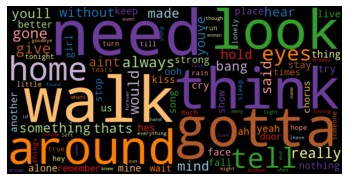

In [18]:
plt.figure()
wordcloud(cher_lyric_df['freq'], max_words=100, stopwords=cher_lyric_df.head(50).index)




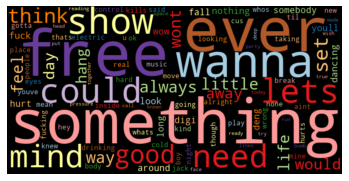

In [19]:
wordcloud(robyn_lyric_df['freq'], max_words=100, stopwords=robyn_lyric_df.head(50).index)


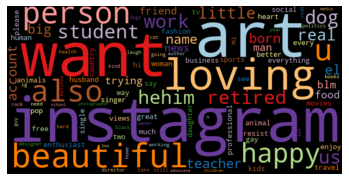

In [20]:
wordcloud(cher_foll_df['freq'], max_words=100, stopwords=cher_foll_df.head(50).index)


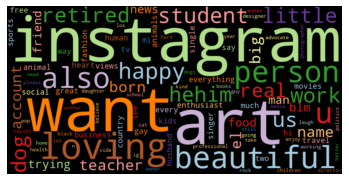

In [21]:
wordcloud(robyn_foll_df['freq'], max_words=100, stopwords=robyn_foll_df.head(50).index)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: I find it very interesting that by using the top 50 most frequent words in each one of the dataframes, it removes a lot of the noise that we saw in the above functions. The wordcoulds seem to contain a lot of very insightful information. I also noticed that Instagram was substantially talked about in the followers data as well. 